# lesson 2

主要内容是读写空间数据，以及如何在Python中使用Geopandas模块和一些有用的数据管理功能处理投影。

## 目标

- 读写Shapefile数据
- 在GeoDataFrame下创建geometries
- 改变数据坐标参考系统

## Geopandas简介

使用Geopandas可以轻松地在python中处理地理空间数据。geopandas将pandas的数据分析库和其他像shapely和fiona之类的管理空间数据的库结合起来。

geopandas中最主要的数据结构是GeoSeries和GeoDataFrame，他们扩展了pandas的Series和DataFrames。也就是说，可以应用pandas的技巧到geopandas的数据结构上。

GeoDataFrames和DataFrames的最主要的区别是一个geodataframe需要包含一列geometries。这列geometry是一个geoseries，它每行都有geometries数据。

使用geopandas的一些基本步骤：

- 管理文件路径
- 读取shapefile
- 几何计算
- 写入shapefile
- 分组，切分空间数据到多图层

### 输入数据

因为该教程是芬兰的老师做的，所以这里给的例子也是芬兰的地理数据库。

### 下载数据

在jupyter lab下打开一个终端，进入到本文件根目录下，执行：

```
$ wget https://github.com/AutoGIS/data/raw/master/L2_data.zip
$ unzip L2_data.zip
$ ls L2_data
```

如果是windows系统，可以[安装wget](https://builtvisible.com/download-your-website-with-wget/)并配置路径，也可以直接去上述地址手动下载，然后解压。

注意，shapefile包括许多文件，比如.dbf文件包含属性信息，.prj文件包含坐标系统的信息。

### 管理文件路径

python的内置os模块有许多可用来和操作系统交互的函数。其中，最常用的就是操作文件路径的os.path模块。

In [1]:
import os

# Define path to folder
input_folder = r"L2_data/NLS/2018/L4/L41/L4132R.shp"

# Join folder path and filename
fp = os.path.join(input_folder, "m_L4132R_p.shp")

# Print out the full file path
print(fp)

L2_data/NLS/2018/L4/L41/L4132R.shp/m_L4132R_p.shp


### 读取shapefile

典型的分析数据的第一步就是读取数据到python中。GIS数据格式有很多，比如Shapefile，GeoJSON，KML和GPKGDENG是最常用的矢量数据格式。Geopandas能够读取所有这些类型的数据。

在geopandas中，我们使用一个泛型函数.from_file()来读取不同类型的数据，geopandas会自动在后台使用fiona.open()来读取数据。

In [2]:
import geopandas as gpd

# Read file using gpd.read_file()
data = gpd.read_file(fp)

type(data)

geopandas.geodataframe.GeoDataFrame

In [3]:
print(data.head())

  TEKSTI  RYHMA  LUOKKA  TASTAR  KORTAR  KORARV  KULKUTAPA    KOHDEOSO  \
0   None     64   32421    5000       0     0.0          0  1812247077   
1   None     64   32421    5000       0     0.0          0  1718796908   
2   None     64   32421   20000       0     0.0          0   411167695   
3   None     64   32421   20000       0     0.0          0   411173768   
4   None     64   32421   20000       0     0.0          0   411173698   

   AINLAHDE SYNTYHETKI  ... KARTOGLK  ALUEJAKOON  VERSUH  SUUNTA  SIIRT_DX  \
0         1   20180125  ...        0           0       0       0         0   
1         1   20180120  ...        0           0       0       0         0   
2         1   20180120  ...        0           0       0       0         0   
3         1   20180120  ...        0           0       0       0         0   
4         1   20180120  ...        0           0       0       0         0   

   SIIRT_DY  KORKEUS  ATTR2  ATTR3  \
0         0      0.0      0      0   
1         

In [6]:
print(data.columns)
print(type(data.columns))
print(data.columns.values)
print(type(data.columns.values))
for column in data.columns.values:
    print(type(column))
    print(column)

Index(['TEKSTI', 'RYHMA', 'LUOKKA', 'TASTAR', 'KORTAR', 'KORARV', 'KULKUTAPA',
       'KOHDEOSO', 'AINLAHDE', 'SYNTYHETKI', 'KUOLHETKI', 'KARTOGLK',
       'ALUEJAKOON', 'VERSUH', 'SUUNTA', 'SIIRT_DX', 'SIIRT_DY', 'KORKEUS',
       'ATTR2', 'ATTR3', 'geometry'],
      dtype='object')
<class 'pandas.core.indexes.base.Index'>
['TEKSTI' 'RYHMA' 'LUOKKA' 'TASTAR' 'KORTAR' 'KORARV' 'KULKUTAPA'
 'KOHDEOSO' 'AINLAHDE' 'SYNTYHETKI' 'KUOLHETKI' 'KARTOGLK' 'ALUEJAKOON'
 'VERSUH' 'SUUNTA' 'SIIRT_DX' 'SIIRT_DY' 'KORKEUS' 'ATTR2' 'ATTR3'
 'geometry']
<class 'numpy.ndarray'>
<class 'str'>
TEKSTI
<class 'str'>
RYHMA
<class 'str'>
LUOKKA
<class 'str'>
TASTAR
<class 'str'>
KORTAR
<class 'str'>
KORARV
<class 'str'>
KULKUTAPA
<class 'str'>
KOHDEOSO
<class 'str'>
AINLAHDE
<class 'str'>
SYNTYHETKI
<class 'str'>
KUOLHETKI
<class 'str'>
KARTOGLK
<class 'str'>
ALUEJAKOON
<class 'str'>
VERSUH
<class 'str'>
SUUNTA
<class 'str'>
SIIRT_DX
<class 'str'>
SIIRT_DY
<class 'str'>
KORKEUS
<class 'str'>
ATTR2
<class 'st

In [59]:
# rename the columns
data = data[['RYHMA', 'LUOKKA',  'geometry']]
colnames = {'RYHMA':'GROUP', 'LUOKKA':'CLASS'}
data.rename(columns=colnames, inplace=True)
data.columns

Index(['GROUP', 'CLASS', 'geometry'], dtype='object')

In [60]:
print("Number of rows", len(data['CLASS']))
print("Number of classes", data['CLASS'].nunique())
print("Number of groups", data['GROUP'].nunique())

Number of rows 4311
Number of classes 20
Number of groups 1


习惯在map上探索数据是极好的，从GeoDataFrame构建一个map是很容易的，可以使用geopandas的.plot函数基于数据的geometries构建map。Geopandas会使用matplotlib构图。

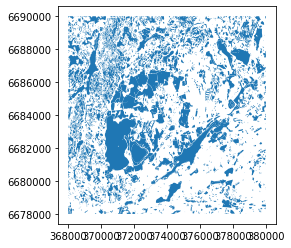

In [61]:
%matplotlib inline
data.plot()

geopandas默认将地图充满整个数据展示面板。

### Geopandas中的Geometries

geopandas利用了shapely中的gometric对象，geometries存储在称作geometry的列中，geometry是默认的列名，在geopandas中存储geometric信息。

In [62]:
print(data['geometry'].head())

0    POLYGON ((379394.248 6689991.936, 379389.790 6...
1    POLYGON ((378980.811 6689359.377, 378983.401 6...
2    POLYGON ((378804.766 6689256.471, 378817.107 6...
3    POLYGON ((379229.695 6685025.111, 379233.366 6...
4    POLYGON ((379825.199 6685096.247, 379829.651 6...
Name: geometry, dtype: geometry


如上结果所示，geometry列中包含shapely的Polygon对象。因为空间数据是一shapely对象的形式存储的，因此在geopandas中处理geometries是可以使用shapely模块的所有功能的。

In [63]:
print("Polygon:", data.at[0, "geometry"])
print("Area:", round(data.at[0, "geometry"].area,0), "square meters")

Polygon: POLYGON ((379394.248 6689991.936, 379389.79 6690000, 379408.646 6690000, 379394.248 6689991.936))
Area: 76.0 square meters


In [64]:
# Iterate over rows and print the area of a Polygon
for index, row in data[0:5].iterrows():
    print(type(row))
    print(type(row['geometry']))
    # Get the area from the shapely-object stored in the geometry-column
    poly_area = row['geometry'].area

    # Print info
    print("Polygon area at index {index} is: {area:.2f} m^2".format(index=index, area=poly_area))

<class 'pandas.core.series.Series'>
<class 'shapely.geometry.polygon.Polygon'>
Polygon area at index 0 is: 76.03 m^2
<class 'pandas.core.series.Series'>
<class 'shapely.geometry.polygon.Polygon'>
Polygon area at index 1 is: 2652.05 m^2
<class 'pandas.core.series.Series'>
<class 'shapely.geometry.polygon.Polygon'>
Polygon area at index 2 is: 3185.65 m^2
<class 'pandas.core.series.Series'>
<class 'shapely.geometry.polygon.Polygon'>
Polygon area at index 3 is: 13075.17 m^2
<class 'pandas.core.series.Series'>
<class 'shapely.geometry.polygon.Polygon'>
Polygon area at index 4 is: 3980.68 m^2


如上代码所示，在geopandas中pandas的所有功能都是可以直接使用的，而且不需要再额外调用pandas，因为geopandas就是pandas的一个扩展。对于面积，geopandas还提供了额外的计算函数：

In [65]:
data.area.head()

0       76.027392
1     2652.054186
2     3185.649995
3    13075.165279
4     3980.682621
dtype: float64

In [66]:
# Create a new column called 'area' and assign the area of the Polygons into it
data['area'] = data.area
data['area'].head()

0       76.027392
1     2652.054186
2     3185.649995
3    13075.165279
4     3980.682621
Name: area, dtype: float64

In [67]:
# Maximum area
max_area = data['area'].max()
# Minimum area
min_area = data['area'].min()
# Mean area
mean_area = data['area'].mean()
print("Max area: {maximum} square meters".format(maximum=round(max_area, 0)))
print("Min area: {minimum} square meters".format(minimum=round(min_area, 0)))
print("Mean area: {mean} square meters".format(mean=round(mean_area, 0)))

Max area: 4084558.0 square meters
Min area: 1.0 square meters
Mean area: 11522.0 square meters


### 写入shapefile

导出GeoDataFrames到各种数据类型使用的是gpd.to_file()函数。

In [69]:
import os
# Select a class，class是data的一个field
selection = data.loc[data["CLASS"]==36200]
# selection = data.loc[0,:]
print(type(selection))
# 如果想导出一行为一个shapefile，但是这时候这行就不是geodataframe属性了，就不对应shapefile了，
# 那怎么办呢？有两种思路：一是要先把它转为geopandas下的数据类型；
# 二是我们可以发现根据条件判断索引的值还是保持GeoDataFrame对象，所以如果要索引，就用条件索引
# 因此如果我想选择一行，那么就先加一列属性index，从0到最后，然后条件判断每行等于索引。那么根据教程推荐，选择第一种试下。
# 具体方式见本文最后一节-creating new layers

# Create a output path for the data
output_folder = r"L2_data/"
# output_fp = os.path.join(output_folder, "Class_36200.shp")
output_fp = os.path.join(output_folder, "one_row.shp")
# Write those rows into a new file (the default output file format is Shapefile)
# selection.to_file(output_fp)

<class 'geopandas.geodataframe.GeoDataFrame'>


### Geodataframe分组

在pandas和geopandas中一个很有用的函数就是.groupby()，它可以根据被选择的列的值对数据进行分组。

In [15]:
data.head()

,GROUP,CLASS,geometry,area
0,64,32421,"POLYGON ((379394.248 6689991.936, 379389.790 6...",76.027392
1,64,32421,"POLYGON ((378980.811 6689359.377, 378983.401 6...",2652.054186
2,64,32421,"POLYGON ((378804.766 6689256.471, 378817.107 6...",3185.649995
3,64,32421,"POLYGON ((379229.695 6685025.111, 379233.366 6...",13075.165279
4,64,32421,"POLYGON ((379825.199 6685096.247, 379829.651 6...",3980.682621


In [16]:
# Print all unique values in the column
print(data['CLASS'].unique())
# Group the data by class
grouped = data.groupby('CLASS')

# Let's see what we have
grouped

[32421 32200 34300 34100 34700 32500 32112 32111 32611 32612 32800 32900
 35300 35412 35411 35421 33000 33100 36200 36313]


In [17]:
grouped.groups.keys()

dict_keys([32111, 32112, 32200, 32421, 32500, 32611, 32612, 32800, 32900, 33000, 33100, 34100, 34300, 34700, 35300, 35411, 35412, 35421, 36200, 36313])

In [18]:
# Iterate over the group object
for key, group in grouped:

    # Let's check how many rows each group has:
    print('Terrain class:', key)
    print('Number of rows:', len(group), "\n")

Terrain class: 32111
Number of rows: 1 

Terrain class: 32112
Number of rows: 1 

Terrain class: 32200
Number of rows: 2 

Terrain class: 32421
Number of rows: 110 

Terrain class: 32500
Number of rows: 2 

Terrain class: 32611
Number of rows: 257 

Terrain class: 32612
Number of rows: 11 

Terrain class: 32800
Number of rows: 80 

Terrain class: 32900
Number of rows: 28 

Terrain class: 33000
Number of rows: 5 

Terrain class: 33100
Number of rows: 118 

Terrain class: 34100
Number of rows: 3005 

Terrain class: 34300
Number of rows: 1 

Terrain class: 34700
Number of rows: 3 

Terrain class: 35300
Number of rows: 134 

Terrain class: 35411
Number of rows: 35 

Terrain class: 35412
Number of rows: 449 

Terrain class: 35421
Number of rows: 5 

Terrain class: 36200
Number of rows: 56 

Terrain class: 36313
Number of rows: 8 



In [19]:
group.head()

,GROUP,CLASS,geometry,area
4303,64,36313,"POLYGON ((377127.305 6688073.257, 377116.045 6...",9619.307973
4304,64,36313,"POLYGON ((371141.897 6677999.999, 371139.757 6...",25266.167705
4305,64,36313,"POLYGON ((371498.720 6680399.799, 371497.585 6...",364.087680
4306,64,36313,"POLYGON ((375668.607 6682942.062, 375671.489 6...",2651.800270
4307,64,36313,"POLYGON ((368411.063 6679328.990, 368411.424 6...",376.503380


In [20]:
type(group)

geopandas.geodataframe.GeoDataFrame

## 地图投影

虽然已经在gis-knowledge一文中介绍过地图投影了，在本项目arcgis文件夹下也记录了使用arcgis时的有关投影的三个半概念，这里还是再补充下在geopandas里是如何处理投影问题的。

坐标参考系统Coordinate reference systems (CRS) 是非常重要的，因为geodataframe的几何shape就是在一个空间下的一系列坐标的集合，而CRS告诉python这些坐标是如何和地球上的位置对应的。

地图投影map projection或者叫projected Coordinate system是经纬度转换为平面坐标的变换，平面坐标上点的单位为m或者decimal degree。不同空间变换的数据是不一样的，因此通常需要把不同的layers reproject到同一个CRS上。这样才能继续分析空间关系。

而投影的选择并是一件很直接简单的事，要根据自己的实际问题，要在地图上表示什么，来选择。实际上，并不存在一个perfect的投影，因为每种投影方式各有利弊，尽量选择最合适的。可以参考[Map Projections](https://xkcd.com/977/)，看看哪种比较合适。

如果想要一个更详细的分析方法来选择投影，可以参考[What's the best map projection?](http://usersguidetotheuniverse.com/index.php/2011/03/03/whats-the-best-map-projection/)

### CRS in Geopandas

幸运的是，在geopands中定义和改变projection是比较简单的。接下来就看看如何获取数据的CRS信息以及如何改变crs。例子是投影WGS84经纬度坐标数据到ambert Azimuthal Equal Area projection上，这是一个欧洲常用的投影（因为AutoGIS项目是由芬兰的老师制作的）。

在shapefile中，CRS信息存储在.prj文件中，此文件十分重要，可不能丢。当使用geopandas读取数据到geodataframe中后，crs信息会自动存储在geodataframe的crs属性中。

In [1]:
# Import necessary packages
import geopandas as gpd

# Read the file
fp = "L2_data/Europe_borders.shp"
data = gpd.read_file(fp)

# Check the coordinate reference system
data.crs

{'init': 'epsg:4326'}

从结果可以看到，crs是一个python的dictionary数据类型数据，其key为init，值为epsg:4326。这是一种典型的存储CRS信息的方式。其他信息稍后再表。

EPSG号码（由European Petroleum Survey Group命名）是在告知数据集的坐标系统。[EPSG Geodetic Parameter Dataset](http://www.epsg.org/)是一个坐标系统和坐标变换的定义集。

这里的实例是epsg:4326，即WGS84坐标系统。关于CRS的信息可以参考如下网站：

- [Spatial Reference](https://spatialreference.org/)
- [Projections](https://proj.org/operations/projections/)
- [	Collection of CRS in Europe](http://mapref.org/CollectionofCRSinEurope.html)

In [2]:
data['geometry'].head()

0    POLYGON ((8.45778 54.56236, 8.44953 54.56269, ...
1    POLYGON ((8.71992 47.69664, 8.72092 47.69530, ...
2    POLYGON ((6.73317 53.57409, 6.73017 53.57542, ...
3    POLYGON ((6.85822 53.59411, 6.85592 53.59550, ...
4    POLYGON ((6.89894 53.62561, 6.88439 53.62814, ...
Name: geometry, dtype: geometry

可以看到坐标都是经纬度数据。现在将其转换为Lambert Azimuthal Equal Area projection (EPSG: 3035) 下的表示。在geopandas中使用.to_crs()函数即可简单实现。该函数有两种参数，1) crs and 2) epgs，都可以用来执行该函数。

In [3]:
# Let's make a backup copy of our data
data_wgs84 = data.copy()

# Reproject the data
data = data.to_crs(epsg=3035)

# Check the new geometry values
print(data['geometry'].head())

0    POLYGON ((4221214.558 3496203.404, 4220681.651...
1    POLYGON ((4224860.478 2732279.320, 4224932.819...
2    POLYGON ((4104652.176 3390034.953, 4104460.401...
3    POLYGON ((4113025.664 3391895.756, 4112879.943...
4    POLYGON ((4115871.228 3395282.099, 4114921.348...
Name: geometry, dtype: geometry


现在对数据可视化看看实际效果。

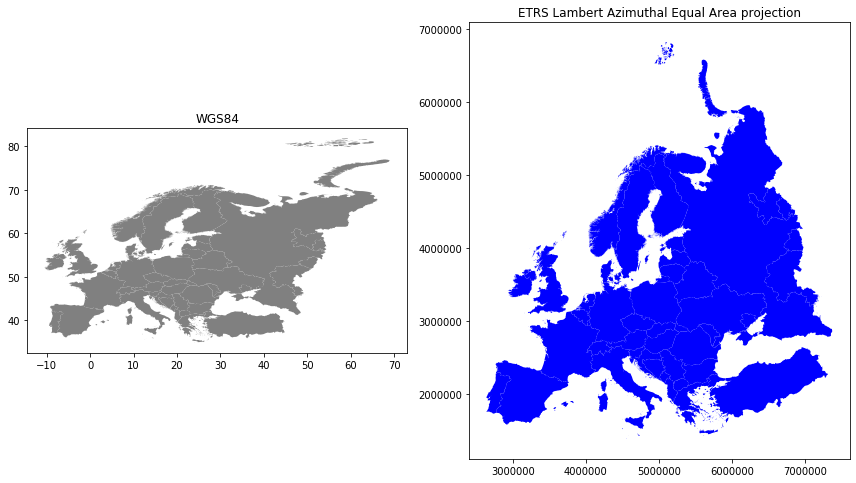

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# Make subplots that are next to each other
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

# Plot the data in WGS84 CRS
data_wgs84.plot(ax=ax1, facecolor='gray');

# Add title
ax1.set_title("WGS84");

# Plot the one with ETRS-LAEA projection
data.plot(ax=ax2, facecolor='blue');

# Add title
ax2.set_title("ETRS Lambert Azimuthal Equal Area projection");

# Remove empty white space around the plot
plt.tight_layout()

可以将投影后的结果存储到shapefile中，以备后用。

In [5]:
# Ouput filepath
outfp = "L2_data/Europe_borders_epsg3035.shp"

# Save to disk， 执行的时候取消下面语句注释。
# data.to_file(outfp)

### 处理不同CRS格式

有许多**表示CRS信息**的方式，比如PROJ strings，EPSG codes，Well-Know-Text（WKT），JSON等。当处理获取到的空间数据时很可能会遇到这些来自不同源的数据。那么将CRS信息从一种格式转换为另一种格式就是件很常见的事情了，所以了解一些技巧是很有必要的。

感谢GIS开源社区的开发者，处理不同CRS信息也是一件容易的事，因为有pyproj库。关于该库的一些介绍，包括安装和基本使用可以参考pyproj文件夹下的文字。pyproj是一个有[OSGeo](https://www.osgeo.org/)社区维护的[PROJ](https://proj.org/)软件的python包装版。广泛应用于各类GIS软件中处理坐标转换。pyproj也在geopandas中使用，它处理所有CRS定义和坐标变换。pyproj库有一个CRS类，提供了很多有用的函数来处理CRS信息。

In [6]:
# Let's see the current CRS of our data
print(data.crs)

{'init': 'epsg:3035', 'no_defs': True}


data.crs能返回CRS信息，但是对于其他如WKT和Proj4等格式需要用到CRS类。(pyproj版本2.4.0以上成功测试)

In [81]:
### Import CRS class from pyproj
from pyproj import CRS

# Initialize the CRS class for epsg code 3035:
crs_object = CRS.from_epsg(3035)
crs_object

<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - LCC & LAEA
- bounds: (-35.58, 24.6, 44.83, 84.17)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

CRS对象相比crs字典数据，包含了更多信息。比如CRS的Name，CRS使用的area，以及Datum。

In [9]:
# Name
print("Name:", crs_object.name)

# Coordinate system
print("Coordinate system:", crs_object.coordinate_system)

# Bounds of the area where CRS is used
print("Bounds:", crs_object.area_of_use.bounds)

Name: ETRS89-extended / LAEA Europe
Coordinate system: cartesian
Bounds: (-35.58, 24.6, 44.83, 84.17)


可以轻松地使用crs_info从CRS中获取所有信息。那么如何从一个格式的crs转换为另一个。如下例，数据格式变为wkt。

In [10]:
# Retrive CRS information in WKT format
crs_wkt = crs_object.to_wkt()
print(crs_wkt)

PROJCRS["ETRS89-extended / LAEA Europe",BASEGEOGCRS["ETRS89",DATUM["European Terrestrial Reference System 1989",ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4258]],CONVERSION["Europe Equal Area 2001",METHOD["Lambert Azimuthal Equal Area",ID["EPSG",9820]],PARAMETER["Latitude of natural origin",52,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",10,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["False easting",4321000,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",3210000,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["northing (Y)",north,ORDER[1],LENGTHUNIT["metre",1]],AXIS["easting (X)",east,ORDER[2],LENGTHUNIT["metre",1]],USAGE[SCOPE["unknown"],AREA["Europe - LCC & LAEA"],BBOX[24.6,-35.58,84.17,44.83]],ID["EPSG",3035]]


从上述结果可以看出，WKT格式包含了更多信息。比如shapefile的prj文件的信息都展示出来了。

也可以从中读取EPSG编号。有时候可能由于缺少一些细节不能读取，那么可以调整min_confidence参数的值。

In [12]:
# Retrieve EPSG code from WKT text
epsg = CRS(crs_wkt).to_epsg()
print(epsg)
# Let's try it again with a lower confidence requirement (25 %)
CRS(data.crs).to_epsg(min_confidence=25)

3035


3035

最后可以输出crs信息。

In [14]:
# Re-define the CRS of the input GeoDataFrame
data.crs = CRS.from_epsg(3035).to_wkt()
print(data.crs)
# Ouput filepath
outfp = "L2_data/Europe_borders_epsg3035.shp"

# Save to disk
data.to_file(outfp)

PROJCRS["ETRS89-extended / LAEA Europe",BASEGEOGCRS["ETRS89",DATUM["European Terrestrial Reference System 1989",ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4258]],CONVERSION["Europe Equal Area 2001",METHOD["Lambert Azimuthal Equal Area",ID["EPSG",9820]],PARAMETER["Latitude of natural origin",52,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",10,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["False easting",4321000,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",3210000,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["northing (Y)",north,ORDER[1],LENGTHUNIT["metre",1]],AXIS["easting (X)",east,ORDER[2],LENGTHUNIT["metre",1]],USAGE[SCOPE["unknown"],AREA["Europe - LCC & LAEA"],BBOX[24.6,-35.58,84.17,44.83]],ID["EPSG",3035]]


另外，还有一个[PyCRS](https://github.com/karimbahgat/PyCRS)的模块也可以用来进行类似的操作。

### 不同crs格式概述

总结使用pyproj CRS代表crs信息的不同方法。

In [80]:
# PROJ dictionary:
crs_dict = data_wgs84.crs

# pyproj CRS object:
crs_object = CRS(data_wgs84.crs)

# EPSG code (here, the input crs information is a bit vague so we need to lower the confidence threshold)
crs_epsg = CRS(data_wgs84.crs).to_epsg()
crs_epsg = CRS(data_wgs84.crs).to_epsg(min_confidence=25)

# PROJ string
crs_proj4 = CRS(data_wgs84.crs).to_proj4()

# Well-Known Text (WKT)
crs_wkt = CRS(data_wgs84.crs).to_wkt()

print("PROJ dictionary:\n", crs_dict)
print("\nCRS object:\n", crs_object)
print("\nEPSG code: \n", crs_epsg)
print("\nPROJ string: \n", crs_proj4)
print("\nWell-Known Text (WKT):\n",crs_wkt)

PROJ dictionary:
 {'init': 'epsg:4326'}

CRS object:
 +init=epsg:4326 +type=crs

EPSG code: 
 4326

PROJ string: 
 +proj=longlat +datum=WGS84 +no_defs +type=crs

Well-Known Text (WKT):
 GEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ID["EPSG",6326]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8901]],CS[ellipsoidal,2],AXIS["longitude",east,ORDER[1],ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],AXIS["latitude",north,ORDER[2],ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],USAGE[SCOPE["unknown"],AREA["World"],BBOX[-90,-180,90,180]]]


### 全球地图投影

一个实例如下。关于全球投影更多的信息可以参考：

- http://geopandas.org/projections.html
- https://pyproj4.github.io/pyproj/dev/api/crs.html
- https://spatialreference.org/

In [21]:
# Read in data
fp = r"L2_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
admin = gpd.read_file(fp)
# Check input crs
admin.crs

{'init': 'epsg:4326'}

Text(0.5, 1, 'WGS84')

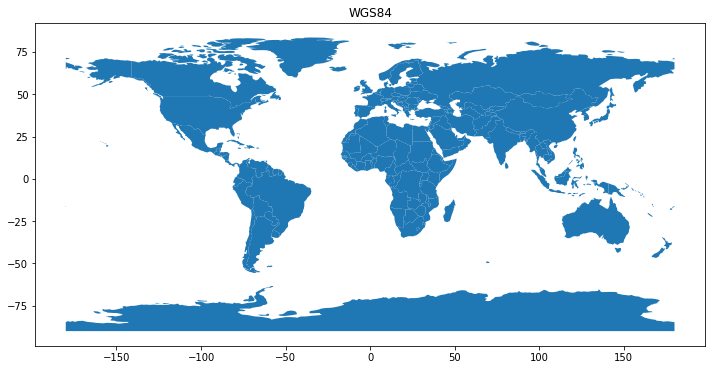

In [23]:
# Set fig size
plt.rcParams['figure.figsize'] = [12, 6]

#Plot in original crs
admin.plot()
plt.title("WGS84")

Text(0.5, 1, 'Web mercator')

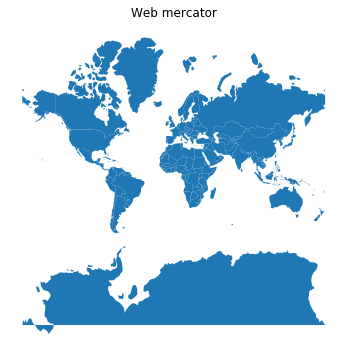

In [24]:
# Define projection as web mercator, 3785
web_mercator = CRS.from_epsg(3785)

# Re-project and plot
admin.to_crs(web_mercator).plot()

# Remove x and y axis
plt.axis('off')
plt.title("Web mercator")

Text(0.5, 1, 'Eckert IV')

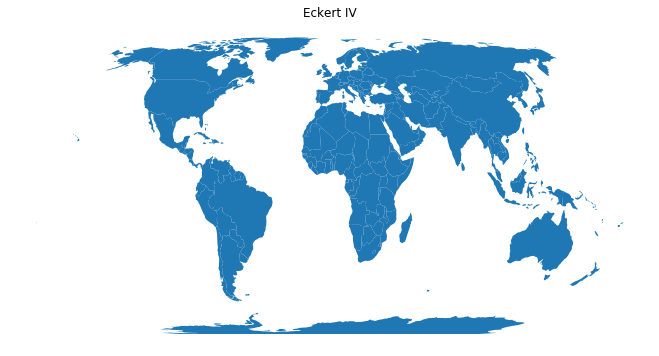

In [25]:
# Define projection Eckert IV from https://spatialreference.org/ref/esri/54012/
eckert_IV = CRS.from_proj4("+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

# Re-project and plot
admin.to_crs(eckert_IV).plot()

# Remove x and y axis
plt.axis('off')
plt.title("Eckert IV")

Text(0.5, 1, 'Orthographic')

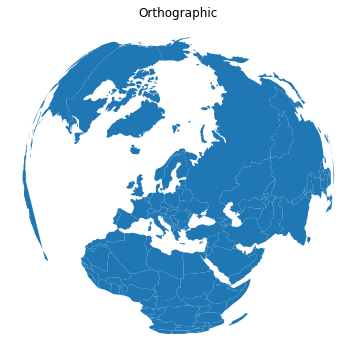

In [26]:
# Define an orthographic projection, centered in Finland! from: http://www.statsmapsnpix.com/2019/09/globe-projections-and-insets-in-qgis.html
ortho = CRS.from_proj4("+proj=ortho +lat_0=60.00 +lon_0=23.0000 +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs")

# Re-project and plot
admin.to_crs(ortho).plot()

# Remove x and y axis
plt.axis('off')
plt.title("Orthographic")

总之，以上就是关于reproject和pyproj CRS的记录。

## Creating new Layers 创建新图层

从前面写入shapefile的操作可以看到，在使用切片取数据时，非条件判断索引时取出的数据是pandas的数据类型，而不是geopandas的了，所以就无法导出成新的图层了。另外，有时候还想转换坐标使用新的坐标系，因此是有必要构建新的geopandas数据结构的。

因为geopandas利用了Shapely的几何对象，因此通过将Shapely的几何对象传递给GeoDataFrame是有可能从头开始构建空间数据的。这在想把一个txt文件转成空间数据集时是很有用的。因此现在就讨论如何从头创建一个新的GeoDataFrame，并存储shapefile。

一个实例：define a geometry that represents the outlines of the Senate square in Helsinki, Finland.

In [11]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pyproj import CRS

newdata = gpd.GeoDataFrame()
print(newdata)

Empty GeoDataFrame
Columns: []
Index: []


现在就有了一个空的GeoDataFrame了，接着就创建geometry列。创建很简单，和pandas的方法是一致的。

In [12]:
# Create a new column called 'geometry' to the GeoDataFrame
newdata['geometry'] = None
print(newdata)

Empty GeoDataFrame
Columns: [geometry]
Index: []


接下来就是写入数据了。创建一个Shapely的Polygon对象（lesson1的基础内容）。

In [13]:
# Coordinates of the Helsinki Senate square in decimal degrees
coordinates = [(24.950899, 60.169158), (24.953492, 60.169158), (24.953510, 60.170104), (24.950958, 60.169990)]
# Create a Shapely polygon from the coordinate-tuple list
poly = Polygon(coordinates)
# Check the polyogon
print(poly)

POLYGON ((24.950899 60.169158, 24.953492 60.169158, 24.95351 60.170104, 24.950958 60.16999, 24.950899 60.169158))


有了数据，就可以将其插入Geodataframe的Geometry列了。

In [14]:
# Insert the polygon into 'geometry' -column at row 0
newdata.at[0, 'geometry'] = poly
# Let's see what we have now
print(newdata)

                                            geometry
0  POLYGON ((24.95090 60.16916, 24.95349 60.16916...


有了一个有Polygon的GeoDataframe，就可以将其导出到shapefile了。不过还需要一些属性信息，这样可以知道一些额外的信息。

In [15]:
# Add a new column and insert data
newdata.at[0, 'location'] = 'Senaatintori'

# Let's check the data
print(newdata)

                                            geometry      location
0  POLYGON ((24.95090 60.16916, 24.95349 60.16916...  Senaatintori


此外，还有一项对与geodataframe来说比较重要的事情，就是CRS了。geodataframe有crs属性可以赋值，目前没有指定就还为空

In [16]:
print(newdata.crs)

None


现在就往其中添加一个crs，因为这里加入的是decimal degrees 的经纬度，所以正确的CRS对应的是WGS84（epsg：4326）

In [27]:
# Set the GeoDataFrame's coordinate system to WGS84 (i.e. epsg code 4326)
newdata.crs = CRS.from_epsg(4326).to_wkt()
print("\nWell-Known Text (WKT):\n",newdata.crs)
print(type(newdata.crs))
print('proj4：',CRS(newdata.crs).to_proj4())
# 从字符串定义一个crs
output_crs_proj4_str='+proj=longlat +datum=WGS84 +no_defs'
output_crs_proj4_str='+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs'
# 注意：好像必须要转到to_wkt才能生成shapefile文件
newdata.crs = CRS.from_proj4(output_crs_proj4_str).to_wkt()


Well-Known Text (WKT):
 GEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["unknown"],AREA["World"],BBOX[-90,-180,90,180]],ID["EPSG",4326]]
<class 'str'>
proj4： +proj=longlat +datum=WGS84 +no_defs +type=crs


从上面结果可以看到现在geodataframe对象中已经有了CRS信息了，这对创建shapefile的.prj文件是至关重要的。最后就可以愉快地导出shapefile文件啦。

In [26]:
# Determine the output path for the Shapefile
outfp = "L2_data/Senaatintori"+'.shp'

# Write the data into that Shapefile
newdata.to_file(outfp)